In [38]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

In [39]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.857156,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.731959,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.883473,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.908735,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.804051,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2019-12-30,AMZN,0.748412,93.699997,94.199997,92.030998,92.344498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7532,2019-12-30,GOOG,0.676151,67.500000,67.650002,66.700996,66.806999,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7533,2019-12-30,GOOGL,0.705876,67.840500,67.849998,66.891998,66.985497,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7534,2019-12-30,MSFT,0.762997,158.990005,159.020004,156.729996,157.589996,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [40]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [41]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1252, 17)
            Date  p_sentiment       Open  ...        tcs    indpro     ccpi
0     2015-01-02     0.857156  27.847500  ...  1069010.0  102.8479  239.811
1     2015-01-05     0.744531  27.072500  ...  1069010.0  102.8479  239.811
2     2015-01-06     0.769826  26.635000  ...  1069010.0  102.8479  239.811
3     2015-01-07     0.773995  26.799999  ...  1069010.0  102.8479  239.811
4     2015-01-08     0.770458  27.307501  ...  1069010.0  102.8479  239.811
...          ...          ...        ...  ...        ...       ...      ...
1246  2019-12-20     0.775477  70.557503  ...  1458485.0  101.6179  265.651
1247  2019-12-23     0.759453  70.132500  ...  1458485.0  101.6179  265.651
1248  2019-12-24     0.742264  71.172501  ...  1458485.0  101.6179  265.651
1249  2019-12-26     0.670220  71.205002  ...  1458485.0  101.6179  265.651
1250  2019-12-27     0.760582  72.779999  ...  1458485.0  101.6179  265.651

[1251 rows x 17 columns]
AMZN (1257, 17)
            Date  p_sentiment 

In [42]:
ticker='TSLA'

In [43]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.741818,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.646626,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.696584,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.654833,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.615611,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [44]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [45]:
dates = pd.to_datetime(df['Date'])

In [46]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [47]:
df_for_training = df[cols].astype(float)

In [48]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [49]:
print(scaled_data)

[[0.78512475 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.57178167 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.68374619 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.47142104 0.97577552 0.99347221 ... 0.57323507 1.         1.        ]
 [0.38496901 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.44112774 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]]


In [50]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [51]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [52]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [53]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1250, 7, 16)
(1250, 1)


In [54]:
X_train=X[0:1125,:]
X_test=X[1125:,:]
y_train=y[0:1125,:]
y_test=y[1125:,:]

#early stopping


Epoch 1/100
6/6 [==============================] - 1s 56ms/step - loss: 0.0141 - val_loss: 0.0214
Epoch 2/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0219 - val_loss: 0.0064
Epoch 3/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 4/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0038 - val_loss: 0.0129
Epoch 5/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0032 - val_loss: 0.0071


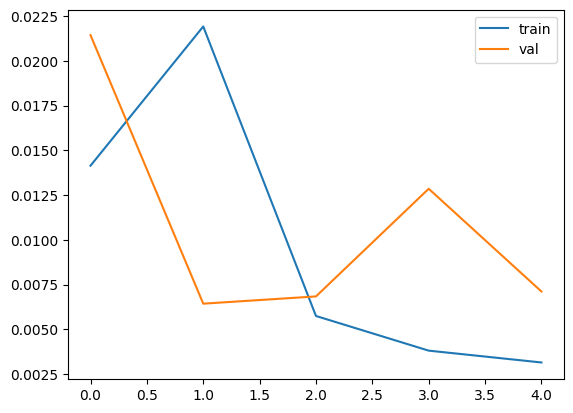

4/4 [==============================] - 0s 4ms/step
(125,)
(125,)


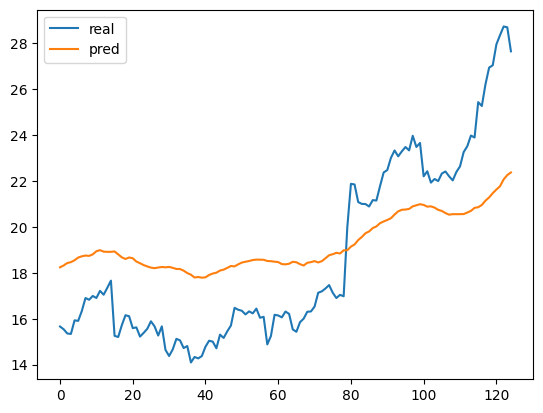

Epoch 1/100
12/12 [==============================] - 1s 37ms/step - loss: 0.0106 - val_loss: 0.0261
Epoch 2/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 3/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 5/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 6/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 8/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 9/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 0.0031


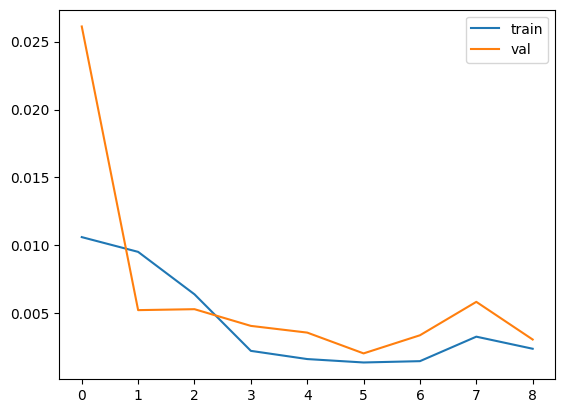

4/4 [==============================] - 0s 4ms/step
(125,)
(125,)


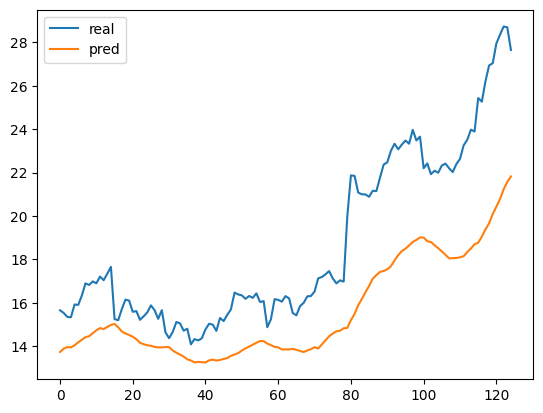

Epoch 1/100
18/18 [==============================] - 2s 33ms/step - loss: 0.0139 - val_loss: 0.0292
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0109 - val_loss: 0.0927
Epoch 3/100
18/18 [==============================] - 0s 24ms/step - loss: 0.0203 - val_loss: 0.0243
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0063 - val_loss: 0.0143
Epoch 5/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0052 - val_loss: 0.0343
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0027 - val_loss: 0.0134
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 8/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 9/100
18/18 [==============================] - 0s 25ms/step - loss: 9.6158e-04 - val_loss: 0.0025
Epoch 10/100
18/18 [==============================] - 0s 26ms/step - loss: 8.7464e-04 - val_loss

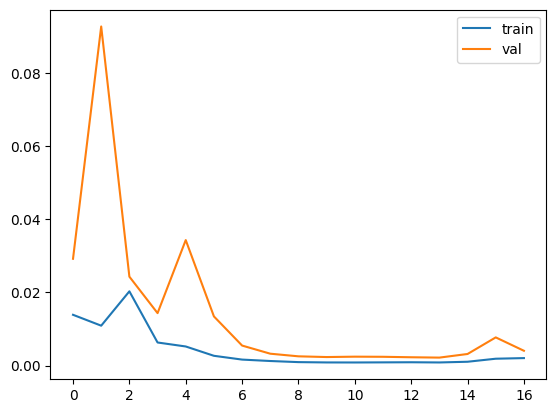

4/4 [==============================] - 0s 6ms/step
(125,)
(125,)


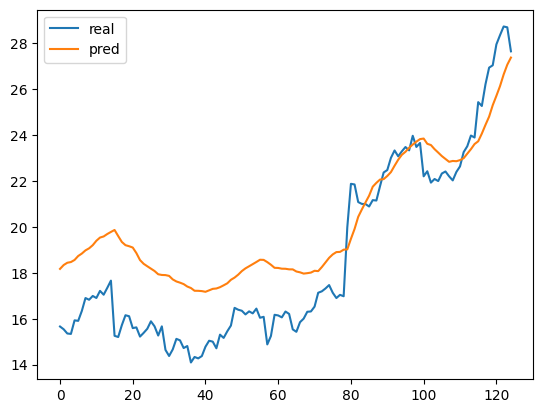

Epoch 1/100
24/24 [==============================] - 2s 31ms/step - loss: 0.0125 - val_loss: 0.0203
Epoch 2/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0336 - val_loss: 0.0114
Epoch 3/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0356 - val_loss: 0.0526
Epoch 4/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0232 - val_loss: 0.0073
Epoch 5/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0121 - val_loss: 0.0194
Epoch 6/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0041 - val_loss: 0.0358
Epoch 7/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0036 - val_loss: 0.0256


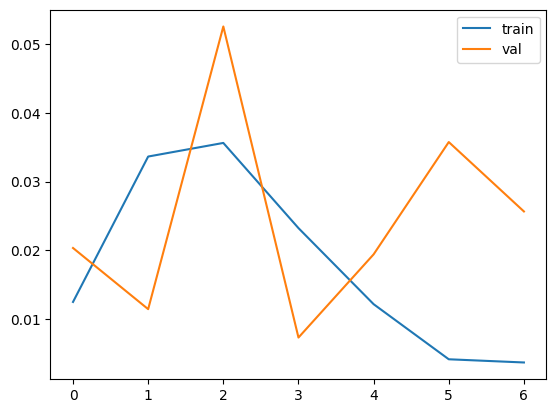

4/4 [==============================] - 0s 5ms/step
(125,)
(125,)


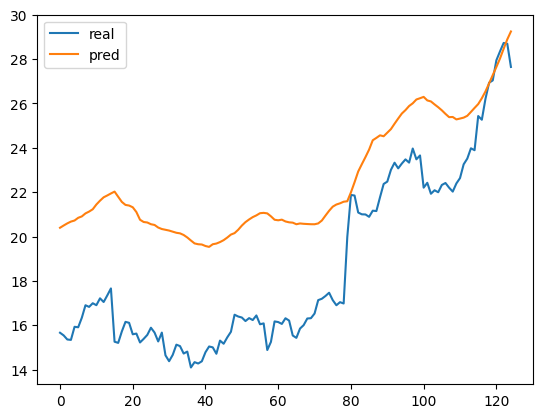

Epoch 1/100
30/30 [==============================] - 2s 29ms/step - loss: 0.0123 - val_loss: 0.0204
Epoch 2/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0240 - val_loss: 0.0358
Epoch 3/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0167 - val_loss: 0.0401
Epoch 4/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0265 - val_loss: 0.0644


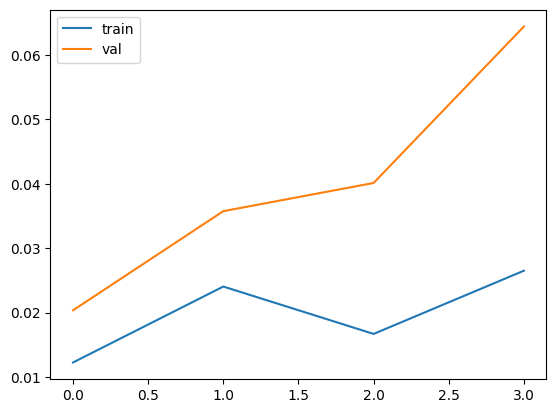

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


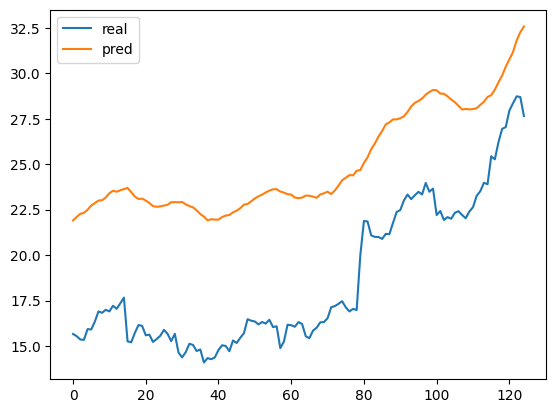

In [55]:
tscv = TimeSeriesSplit(n_splits=5)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=3)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(Bidirectional(LSTM(256,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=False)))
    #model.add(LSTM(3,activation='relu',return_sequences=False))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()


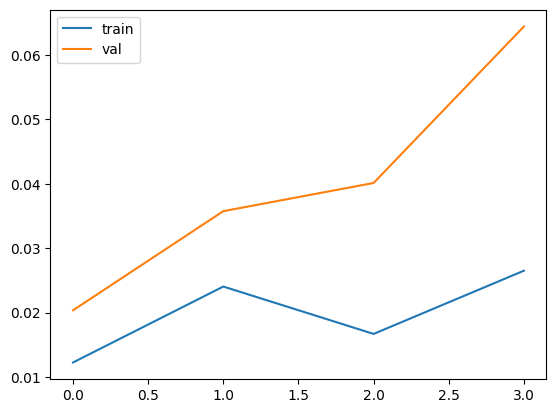

In [56]:
# plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [57]:
#evaluate model
